###### Tringa Demiri : 11845777

# Question 1 a - c


In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


df = pd.read_csv("debates_2022.csv")


# Dropped rows with missing or empty 'talk_text'
df = df.dropna(subset=["talk_text"])
df = df[df["talk_text"].str.strip() != ""]

# Cleaned text
def preprocess_text(text):
    text = re.sub(r"\d+", "", text)  # removing digits
    text = re.sub(r"[^\w\s]", "", text)  # removing punctuation
    text = text.lower()  # lowercase
    return text

df["cleaned_text"] = df["talk_text"].apply(preprocess_text)


vectorizer = TfidfVectorizer(
    max_features= 100000,               # limitting to 100,000 most informative features
    stop_words='english',             # removing English stopwords
    ngram_range=(1, 2),               # using unigrams and bigrams
    min_df=5,                         # ignoring terms that appear in less than 5 documents
    max_df=0.9                        # ignoring terms that appear in more than 90% of documents
)

tfidf_matrix = vectorizer.fit_transform(df["cleaned_text"])


print("Number of features extracted:", len(vectorizer.get_feature_names_out()))


Number of features extracted: 45554


# 2 a - d

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Reusing the tfidf_matrix from Question 1

# Trying multiple values of k to find the best number of clusters until 12 since more than that the clusters start to be redundant and overseparate
sil_scores = []
k_values = range(2, 13)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)
    print(f"k={k}, Silhouette Score={score:.4f}")

# Selecting best k (highest silhouette score)
best_k = k_values[np.argmax(sil_scores)]
print("Best number of clusters based on silhouette score:", best_k) # k = 2 is the highest score, but that amount of k's would explain practically nothing




k=2, Silhouette Score=0.0103
k=3, Silhouette Score=0.0041
k=4, Silhouette Score=0.0049
k=5, Silhouette Score=0.0056
k=6, Silhouette Score=0.0062
k=7, Silhouette Score=0.0065
k=8, Silhouette Score=0.0066
k=9, Silhouette Score=0.0071
k=10, Silhouette Score=0.0072
k=11, Silhouette Score=0.0075
k=12, Silhouette Score=0.0076
Best number of clusters based on silhouette score: 2


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Using the tfidf_matrix from earlier
k = 12                               # manually chosen for better topic granularity
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(tfidf_matrix)

# Evaluation
sil_score = silhouette_score(tfidf_matrix, labels_final)
print(f"Silhouette Score for k=12: {sil_score:.4f}")

# Top words per cluster
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans_final.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i+1} Top Words:", ", ".join(top_words))


Silhouette Score for k=12: 0.0076
Cluster 1 Top Words: women, violence, gender, rights, abortion, girls, womens, equality, sexual, men
Cluster 2 Top Words: young, youth, young people, mental, mental health, health, people, year, year youth, european year
Cluster 3 Top Words: closed, written statements, discussion, discussion closed, statements, written, statements article, closed vote, article, vote
Cluster 4 Top Words: rights, human rights, human, people, european, china, freedom, journalists, president, fundamental
Cluster 5 Top Words: mr, european, president, commission, think, people, need, member, eu, states
Cluster 6 Top Words: climate, food, farmers, need, european, change, mr, production, climate change, sustainable
Cluster 7 Top Words: ukraine, war, russia, russian, putin, ukrainian, european, people, europe, support
Cluster 8 Top Words: energy, gas, prices, need, renewable, european, price, electricity, nuclear, crisis
Cluster 9 Top Words: schengen, romania, bulgaria, croatia

# 3 a-c

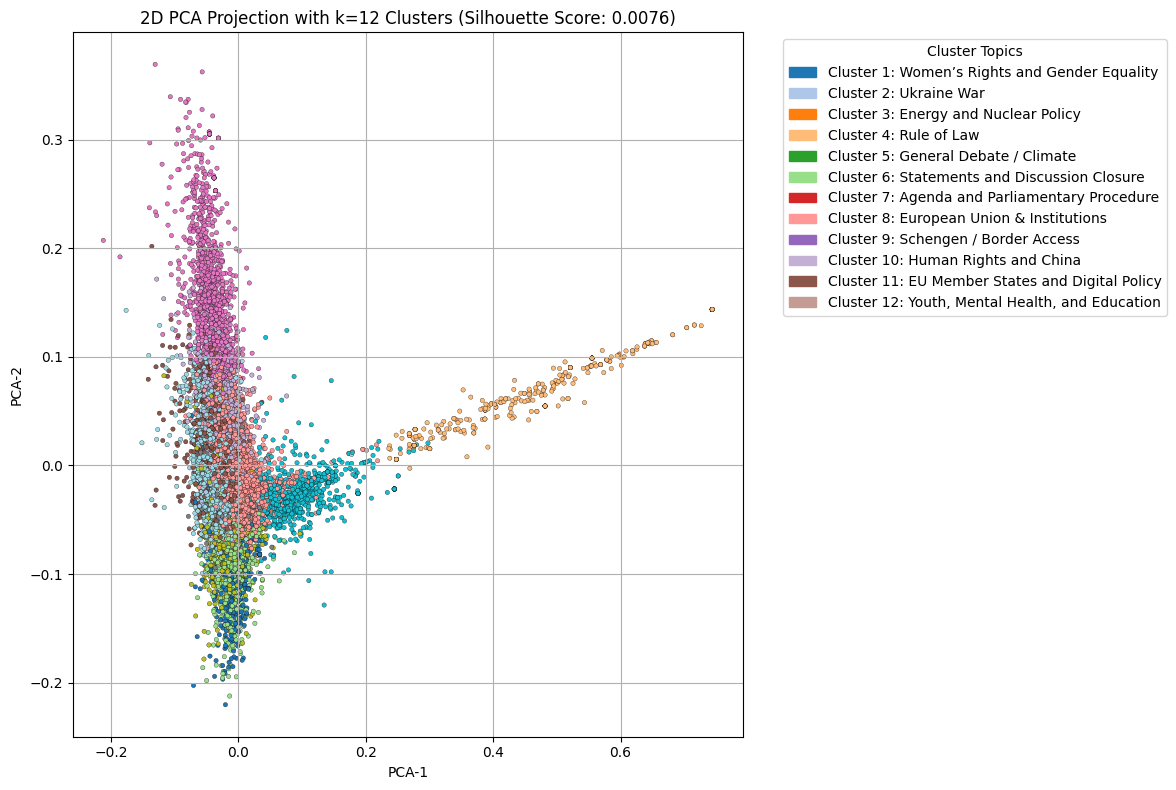

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


kmeans_k12 = KMeans(n_clusters=12, random_state=42, n_init=10)
labels_k12 = kmeans_k12.fit_predict(tfidf_matrix)

# PCA to 2D 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(tfidf_matrix.toarray())

#Topics that best describe the list above
cluster_topics = {
    0: "Women’s Rights and Gender Equality",
    1: "Ukraine War",
    2: "Energy and Nuclear Policy",
    3: "Rule of Law",
    4: "General Debate / Climate",
    5: "Statements and Discussion Closure",
    6: "Agenda and Parliamentary Procedure",
    7: "European Union & Institutions",
    8: "Schengen / Border Access",
    9: "Human Rights and China",
    10: "EU Member States and Digital Policy",
    11: "Youth, Mental Health, and Education"
}


plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_k12, cmap='tab20', s=10, edgecolors='k', linewidth=0.2)
plt.title("2D PCA Projection with k=12 Clusters (Silhouette Score: 0.0076)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)

# Legend: all used clusters
patches = [mpatches.Patch(color=plt.cm.tab20(i), label=f"Cluster {i+1}: {cluster_topics[i]}") for i in range(12)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster Topics")

plt.tight_layout()
plt.show()


# 4 a - c

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("king_rook_vs_king.csv")

#Preprocessing
depth_map = {
    'draw': 0,
    'zero': 1, 'one': 1, 'two': 1, 'three': 1, 'four': 1,
    'five': 2, 'six': 2, 'seven': 2, 'eight': 2,
    'nine': 3, 'ten': 3, 'eleven': 3, 'twelve': 3,
    'thirteen': 4, 'fourteen': 4, 'fifteen': 4, 'sixteen': 4
}

df['win_depth'] = df['white_depth_of_win'].map(depth_map)
file_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}

for col in ['white_king_file', 'white_rook_file', 'black_king_file']:
    df[col] = df[col].map(file_map)


# Features and target
X = df[['white_king_file', 'white_king_rank', 'white_rook_file', 'white_rook_rank',
        'black_king_file', 'black_king_rank']]

y = df['win_depth']

# Model
model = RandomForestClassifier(random_state=42)

# Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Cross validation 
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

# Evaluating best model
best_model = grid.best_estimator_
y_best = best_model.predict(X_test)
print(classification_report(y_test, y_best))


              precision    recall  f1-score   support

           0       0.89      0.85      0.87       549
           1       0.99      0.84      0.91       130
           2       0.94      0.92      0.93       636
           3       0.94      0.94      0.94      2072
           4       0.94      0.96      0.95      2225

    accuracy                           0.94      5612
   macro avg       0.94      0.90      0.92      5612
weighted avg       0.94      0.94      0.94      5612

Best params: {'max_depth': None, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       549
           1       1.00      0.85      0.92       130
           2       0.93      0.90      0.92       636
           3       0.93      0.94      0.94      2072
           4       0.95      0.96      0.95      2225

    accuracy                           0.94      5612
   macro avg       0.94      0.90      0.92      5612
weighted avg       0.94